<a href="https://colab.research.google.com/github/chloelee-0007/computer-vision-paper/blob/main/unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-. 순환 신경망을 활용한 문자열 생성

https://www.tensorflow.org/tutorials/text/text_generation?hl=ko

이 튜토리얼은 수정된 <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>을 사용하여 이미지 분할 작업에 중점을 둡니다.

## 이미지 분할이란?

이미지 분류 작업에서 네트워크는 각 입력 이미지에 레이블(또는 클래스)을 할당합니다. 그러나 해당 객체의 모양, 어떤 픽셀이 어떤 객체에 속하는지 등을 알고 싶다고 가정해 보겠습니다. 이 경우 이미지의 각 픽셀에 클래스를 할당해야 할 것입니다. 이 작업을 세분화라고 합니다. 세분화 모델은 이미지에 대한 훨씬 더 자세한 정보를 반환합니다. 이미지 분할은 의료 영상, 자율 주행 자동차, 위성 영상 등 여러 분야에 응용됩니다.

이 튜토리얼은 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)([Parkhi 등, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf))을 사용합니다. 이 데이터세트는 37개의 애완동물 품종의 이미지로 구성되어 있으며 품종당 200개의 이미지가 있습니다(훈련 및 테스트 분할에 각각 ~100개). 각 이미지에는 해당 레이블과 픽셀 단위 마스크가 포함됩니다. 마스크는 각 픽셀에 대한 클래스 레이블입니다. 각 픽셀에는 세 가지 범주 중 하나가 지정됩니다.

- 클래스 1: 애완 동물에 속하는 픽셀
- 클래스 2: 애완동물과 접하는 픽셀
- 클래스 3: 위에 속하지 않음/주변 픽셀

In [ ]:
# 개 or 고양이가 있음
# classification을 하기 위함
# 얼굴 부분이 boundary box 가 쳐져있음, 사진 1개에 한 마리가 있음
# segmentation file을 이용해서 segmentation을 함

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-gqor5mi1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-gqor5mi1
  Resolved https://github.com/tensorflow/examples.git to commit a71f7e38b0ce56e9f39d8049e836ea8f7af74f83
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

# output 을 clear
# from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Pets 데이터 세트를 다운로드 하기

데이터세트는 [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)에서 사용할 수 있습니다. 세분화 마스크는 버전 3+에 포함되어 있습니다.

In [ ]:
# info 를 같이 넘겨준다
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

또한 이미지 색상 값은 `[0,1]` 범위로 정규화됩니다. 마지막으로 위에서 언급한 것처럼 분할 마스크의 픽셀에는 {1, 2, 3}이라는 레이블이 지정됩니다. 편의를 위해 세분화 마스크에서 1을 빼면 {0, 1, 2}와 같은 레이블이 생성됩니다.

In [ ]:
# normalization 한다. input image / 255
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

데이터세트에는 이미 필요한 훈련 및 테스트 분할이 포함되어 있으므로 동일한 분할을 계속 사용하세요.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
# 한 epoch 에 몇 batch_size 가 필요한지?
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
# 3680 57
print(TRAIN_LENGTH, STEPS_PER_EPOCH )

3680 57


In [ ]:
# parallel processing 갯수 AUTO, 최적의 숫자를 알아서 넣어줌
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
info
        # 'test': <SplitInfo num_examples=3669, num_shards=4>,
        # 'train': <SplitInfo num_examples=3680, num_shards=4>,

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [ ]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

다음 클래스는 이미지를 무작위로 뒤집어 간단한 증강을 수행합니다. 자세히 알아보려면 [이미지 증강](data_augmentation.ipynb) 튜토리얼로 이동하세요.


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

입력을 일괄 처리한 후 증강을 적용하여 입력 파이프라인을 빌드합니다.

In [ ]:
# cache : 메모리에 올림, 속도가 빨라짐
# repeat : keras 에서는 반드시 쓸 것! epoch 을 돌 때 끝까지 data 사용함
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

데이터세트에서 이미지 예제와 해당 마스크를 시각화합니다.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

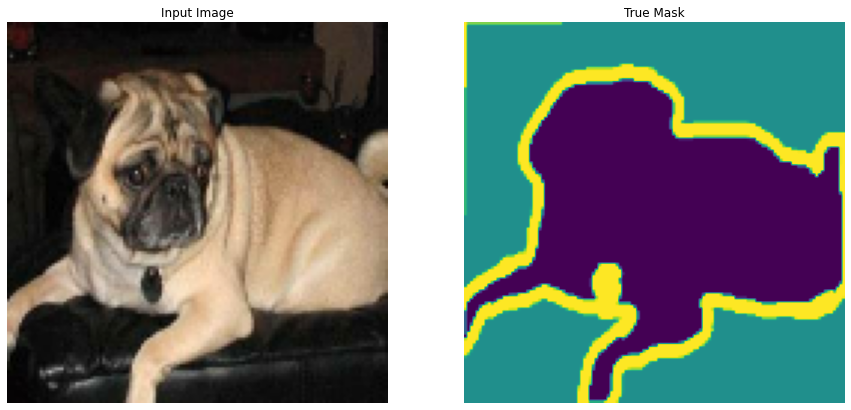

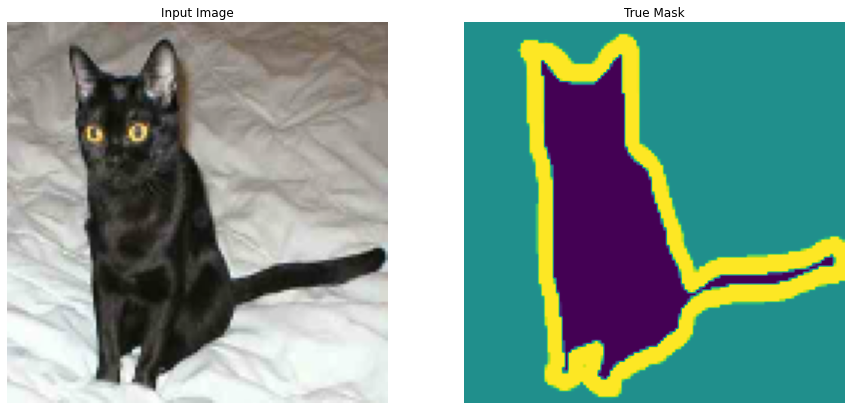

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])
# 0.1.2 : 경계, 안쪽, background
# class 가 3개임  

## 모델 정의하기

여기에 사용된 모델은 수정된 [U-Net](https://arxiv.org/abs/1505.04597)입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)로 구성됩니다. 강력한 기능을 학습하고 학습 가능한 매개변수의 수를 줄이기 위해 사전 학습된 모델인 [MobileNetV2](https://arxiv.org/abs/1801.04381)를 인코더로 사용합니다. 디코더의 경우 TensorFlow 예제 리포지토리의 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 예제에서 이미 구현된 업샘플 블록을 사용합니다. 노트북에서 [pix2pix: 조건부 GAN을 사용한 이미지 대 이미지 변환](../generative/pix2pix.ipynb) 튜토리얼을 확인하세요.


언급했듯이 인코더는 사전 학습된 MobileNetV2 모델입니다. `tf.keras.applications`의 모델을 사용합니다. 인코더는 모델의 중간 레이어에서 얻어지는 특정 출력으로 구성됩니다. 인코더는 학습 과정에서 훈련되지 않습니다.

In [ ]:
# pretrained 된 model 이 많다
# tf.keras.applications.mobilenet_v2
# tf.keras.applications.vgg16

In [ ]:
# include_top=False : 마지막 fully connect layer 를 가져오지 않는다
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
# encorder --> decoder 로 전환할 때 사용함
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

디코더/업샘플러는 TensorFlow 예제에서 구현된 일련의 업샘플 블록입니다.

In [ ]:
# upsample : Sequencial -> Transpose(strides=2) -> batch norm -> dropout -> relu
# upsample(filters, size, norm_type='batchnorm', apply_dropout=False)
# 입력은 128까지 키워야 하는데 마지막 layer는 별도로 한다. upsample에서는 relu 를 쓰는데 마지막 layer는 softmax를 쓰기 때문임
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  # 줄어드는 것은 완료

  # skip connecton
  skips = down_stack(inputs)
  # 마지막 4*4 -> 8*8 -> 16x16 -> 32x32
#   layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
  x = skips[-1]
  # layer_names 와 역순으로 진행
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  # concat 합쳐줌
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 마지막 layer 는 별도로 한다
  # This is the last layer of the model
  # activation = 'softmax'
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

마지막 레이어의 필터 수는 `output_channels`의 수로 설정됩니다. 이것은 클래스당 하나의 출력 채널이 됩니다.

## 모델 훈련하기

이제 모델을 컴파일하고 훈련하는 일만 남았습니다.

이것은 다중 클래스 분류 문제이므로 `from_logits` 인수가 `True`로 설정된 `tf.keras.losses.CategoricalCrossentropy` 손실 함수를 사용하세요. 레이블은 모든 클래스의 각 픽셀에 대한 점수 벡터가 아니라 정수 스칼라이기 때문입니다.

추론을 실행할 때 픽셀에 할당된 레이블은 값이 가장 높은 채널입니다. 이것이 `create_mask` 함수가 하는 일입니다.

In [ ]:
# 0.1.2 : 경계, 안쪽, background
# class 가 3개임  
# SparseCategoricalCrossentropy : 숫자 0,1,2 로 되어 있기 때문임
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

결과적인 모델 아키텍처를 플로팅합니다.

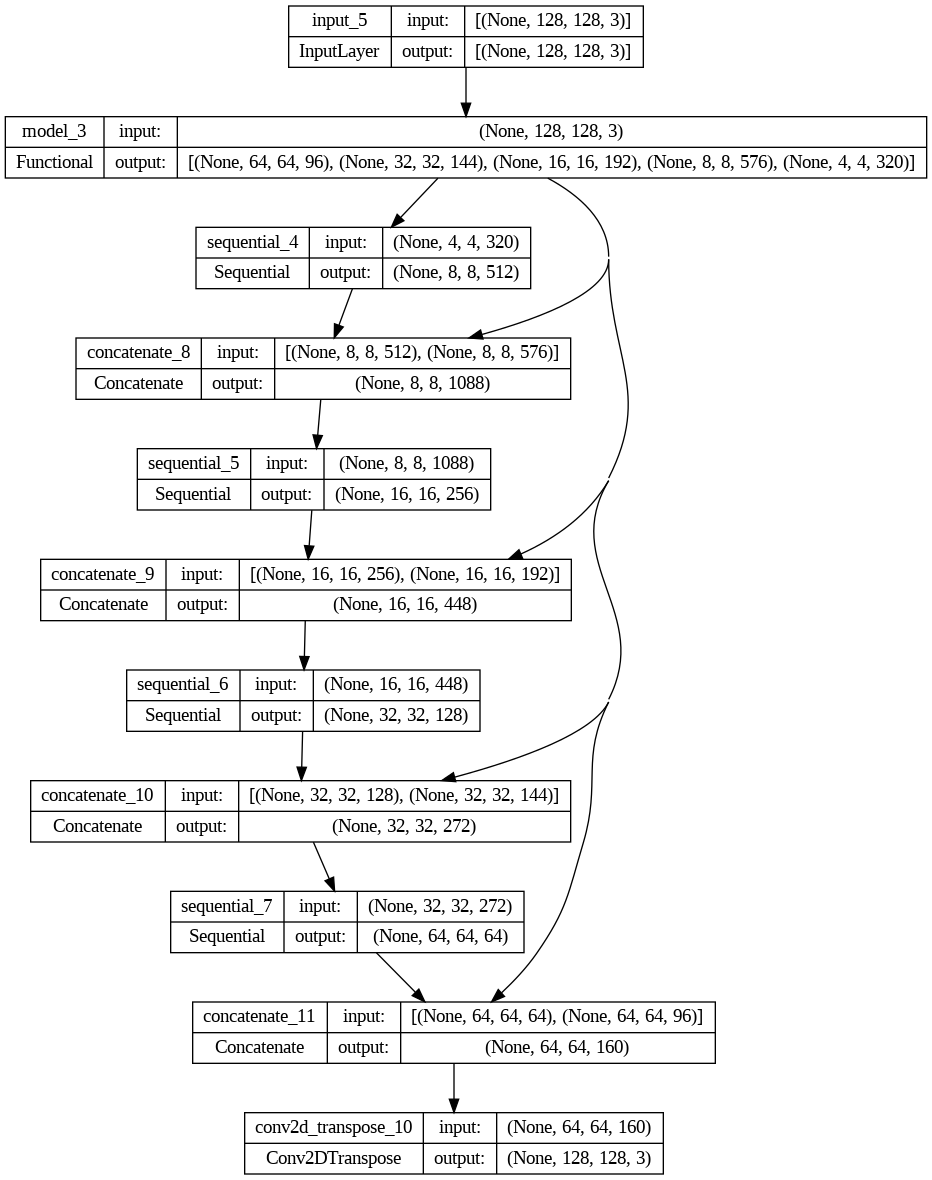

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

훈련 전에 모델이 예측하는 것을 확인하기 위해 모델을 시험해 보세요.

In [ ]:
# 채널 방향에서 3개 중 max의 index 를 return
# output 의 prediction 을 구함
# tf.newaxis : 하나 늘림, 1을 채움, 4차원 : batchsize, height, weight, channel
# channel이 사라졌기 때문에 하나 늘려줌
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      # 내가 예측한 mask
      pred_mask = model.predict(image)
      # image, 정답, 내가 예측한 mask
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 866ms/step


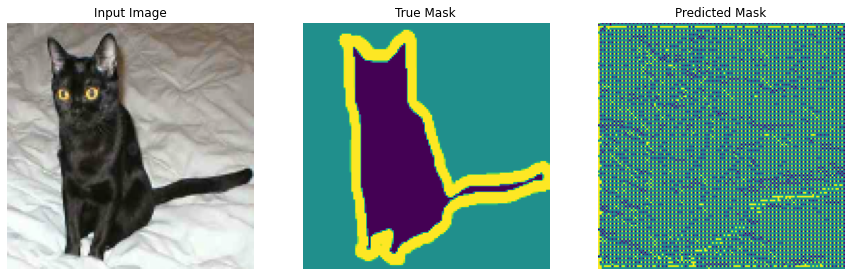

In [ ]:
show_predictions()
# train 을 안해서 제대로 나오지 않음

아래에 정의된 콜백은 모델이 훈련되는 동안 어떻게 개선되는지 관찰하는 데 사용됩니다.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # 한 epoch 이 끌날 때마다 수행
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 24ms/step


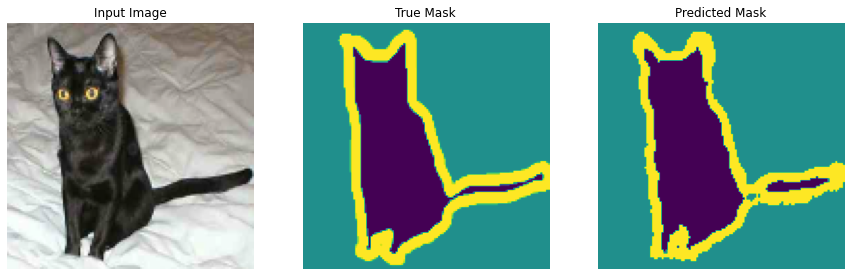


Sample Prediction after epoch 20

57/57 [==============================] - 10s 170ms/step - loss: 0.1339 - accuracy: 0.9388 - val_loss: 0.3170 - val_accuracy: 0.8909


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

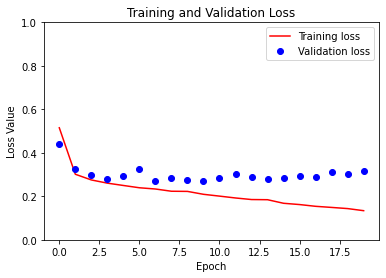

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 예측하기

이제 몇 가지 예측을 하겠습니다. 시간을 절약하기 위해 epoch 수를 작게 유지했지만 더 정확한 결과를 얻으려면 이 값을 더 높게 설정할 수 있습니다.

2/2 [==============================] - 0s 66ms/step


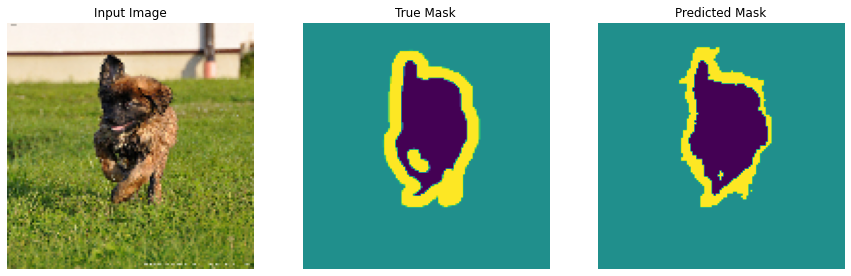

2/2 [==============================] - 0s 63ms/step


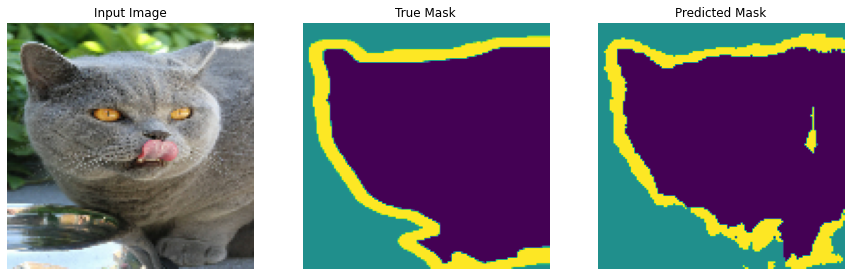

2/2 [==============================] - 0s 64ms/step


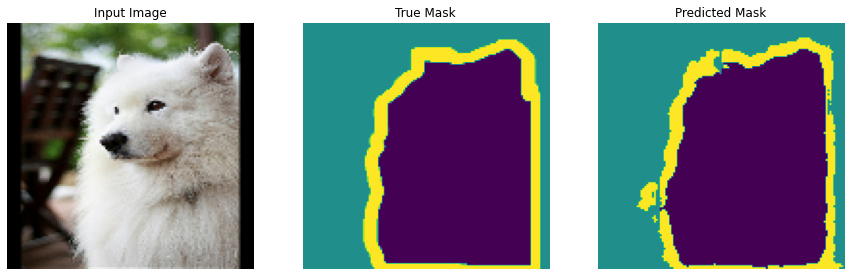

In [ ]:
show_predictions(test_batches, 3)

## 옵션: 불균형 클래스 및 클래스 가중치

시맨틱 분할 데이터세트는 불균형이 심할 수 있습니다. 즉, 특정 클래스 픽셀이 다른 클래스의 픽셀보다 이미지 내부에 더 많이 존재할 수 있습니다. 분할 문제는 픽셀별 분류 문제로 취급될 수 있으므로, 이를 설명하기 위해 손실 함수에 가중치를 주어 불균형 문제를 처리할 수 있습니다. 이것이 이 문제를 처리하는 간단하고 무리 없는 방법입니다. 자세한 내용은 [불균형 데이터에 대한 분류](../structured_data/imbalanced_data.ipynb) 튜토리얼을 참조하세요.

[모호성을 피하기 위해](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748) `Model.fit`은 3차원 이상의 입력에 대해 `class_weight` 인수를 지원하지 않습니다.

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


따라서 이 경우 가중치를 직접 구현해야 합니다. 샘플 가중치를 사용하여 이 작업을 수행합니다. `(data, label)` 쌍 외에 `Model.fit`는 `(data, label, sample_weight)` 트리플도 허용합니다.

Keras `Model.fit`은 `sample_weight`를 손실 및 메트릭으로 전파하며 `sample_weight` 인수도 허용합니다. 샘플 가중치는 감소 단계 이전의 샘플 값으로 곱해집니다. 예를 들면 다음과 같습니다.

In [ ]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

따라서 이 튜토리얼을 위한 샘플 가중치를 만들려면 `(data, label)` 쌍을 받아서 `(data, label, sample_weight)` 트리플을 반환하는 함수가 필요합니다. 여기서 `sample_weight`는 각 픽셀에 대한 클래스 가중치를 포함하는 1채널 이미지입니다.

가장 간단한 구현은 레이블을 `class_weight` 목록에 대한 인덱스로 사용하는 것입니다.

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

결과 데이터세트 요소에는 각각 3개의 이미지가 포함됩니다.

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

이제 가중치 적용된 이 데이터세트에서 모델을 훈련할 수 있습니다.

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 4s 119ms/step - loss: 0.2684 - accuracy: 0.6590
